In [1]:
from skfem import *
import numpy as np

This example solves the obstacle problem
$$
\begin{aligned}
- \frac{\partial^2 u}{\partial x^2} - \lambda &= 0\\
u - g &\geq 0 \\
\lambda &\geq 0 \\
\lambda(u - g) &= 0
\end{aligned}
$$
using $P_2 - P_0$ finite elements and simple fixed point iteration over the active set.

In [2]:
xs = np.linspace(0, 1, 50)
m = MeshLine(xs)
e = ElementLineP2()
el = ElementLineP0()
basis = Basis(m, e)
basisl = basis.with_element(el)

@BilinearForm
def laplace(u, v, w):
    from skfem.helpers import dot, grad
    return dot(grad(u), grad(v))

@BilinearForm
def mass(u, mu, w):
    return u * mu

def gfun(x):
    return -np.cos(2. * np.pi * x)

@LinearForm
def obstacle(v, w):
    return gfun(w.x[0]) * v

A = laplace.assemble(basis)
M = mass.assemble(basis, basisl)
g = obstacle.assemble(basisl)

from scipy.sparse import bmat

act = np.arange(basisl.N, dtype=np.int64)
D1 = basis.get_dofs()

for itr in range(10):

    K = bmat([[A, -M[act].T],
              [-M[act], None]]).tocsr()
    F = np.concatenate((
        np.zeros(A.shape[0]),
        -g[act]
    ))

    x = solve(*condense(K, F, D=D1))
    lam = np.zeros(basisl.N)
    lam[act] = x[basis.N:] 
    act = np.nonzero(lam > 0)[0]

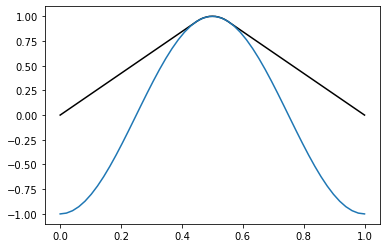

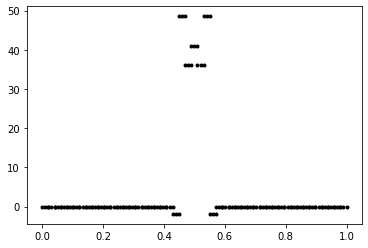

In [3]:
from skfem.visuals.matplotlib import plot, draw

ax = plot(basis, x[:basis.N], color='k-')
ax.plot(xs, gfun(xs))
plot(basisl, lam, color='k.')